# Geo-navigation with Strapdown Sim

We'll use this notebook to explore geophysical map-matching to aid degraded INS navigation.

First let's pull the coordinates and develop a measurement model parameters for magnetic and gravity anomaly maps

In [2]:
import os
import sys
import numpy as np
from pathlib import Path
import pandas as pd
import pygmt
from haversine import haversine_vector, Unit
from matplotlib import pyplot as plt
from matplotlib.figure import Figure, SubFigure
from cartopy import crs as ccrs
from cartopy.io import img_tiles as cimgt
from typing import Optional
import xarray as xr


ROOT = Path(".").resolve()

def find_strapdown_bin() -> Path:
    if "STRAPDOWN_BIN" in os.environ:
        return Path(os.environ["STRAPDOWN_BIN"])
    exe = "strapdown-sim.exe" if sys.platform.startswith("win") else "strapdown-sim"
    cand = Path().resolve().parents[1] / "target" / "release" / exe
    if cand.exists():
        return cand
    raise FileNotFoundError("strapdown-sim not found. Build with `pixi run cargo build --workspace --release`.")

def find_geonav_bin() -> Path:
    if "GEONAV_BIN" in os.environ:
        return Path(os.environ["GEONAV_BIN"])
    exe = "geonav-sim.exe" if sys.platform.startswith("win") else "geonav-sim"
    cand = Path().resolve().parents[1] / "target" / "release" / exe
    if cand.exists():
        return cand
    raise FileNotFoundError("geonav-sim not found. Build with `pixi run cargo build --workspace --release`.")


def plot_results(scenario:str, title_str:str = "") -> Figure | SubFigure:
    """Performance visualization plot helper"""
    truth = pd.read_csv(ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True)
    df = pd.read_csv(ROOT.joinpath("out", f'{scenario}.csv'), index_col=0, parse_dates=True)
    truth_coords = truth[["latitude", "longitude", "altitude"]].copy().to_numpy()
    df_coords = df[["latitude", "longitude", "altitude"]].copy().to_numpy()

    two_d_error = haversine_vector(truth_coords[1:, :2], df_coords[1:, :2], Unit.METERS)
    time = (df.index - df.index[0]).total_seconds()
    plt.figure(figsize=(18, 6))
    plt.plot(time[1:], two_d_error)

    plt.xlim(left=0)
    plt.ylim((0, 150))

    plt.xlabel('Time (s)')
    plt.ylabel('Haversine Error (m)')
    plt.title(f'Simulation: {title_str}')
    #plt.legend()
    plt.grid()
    return plt.gcf()


def inflate_bounds(
    min_x: float, min_y: float, max_x: float, max_y: float, inflation_percent: float
) -> tuple[float, float, float, float]:
    width = max_x - min_x
    height = max_y - min_y
    if width <= 1e-6:
        width = 0.1
    if height <= 1e-6:
        height = 0.1
    inflate_x = width * inflation_percent
    inflate_y = height * inflation_percent
    new_min_x = min_x - inflate_x
    new_min_y = min_y - inflate_y
    new_max_x = max_x + inflate_x
    new_max_y = max_y + inflate_y
    return new_min_x, new_min_y, new_max_x, new_max_y


def plot_route(cleaned_data: pd.DataFrame, output_path: str | Path, title: Optional[str] = None) -> Figure | SubFigure:
    """
    Plot the route from cleaned data and save to output_path.
    """
    west_lon = cleaned_data["longitude"].min()
    east_lon = cleaned_data["longitude"].max()
    south_lat = cleaned_data["latitude"].min()
    north_lat = cleaned_data["latitude"].max()
    west_lon, south_lat, east_lon, north_lat = inflate_bounds(west_lon, south_lat, east_lon, north_lat, 0.1)
    extent = [west_lon, east_lon, south_lat, north_lat]
    request = cimgt.GoogleTiles()
    ax = plt.axes(projection=request.crs)
    ax.set_extent(extent)  # type: ignore
    ax.add_image(request, 15)  # type: ignore
    ax.scatter(
        cleaned_data["longitude"],
        cleaned_data["latitude"],
        0.5,
        color="red",
        transform=ccrs.PlateCarree(),
    )
    if title:
        ax.set_title(title)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Route plot saved to {output_path}.")
    return ax.figure

In [88]:
coords = np.empty((0, 3))  # lat, lon, alt
grav = np.empty((0, 3)) 
mag = np.empty((0, 3))  

In [89]:
from glob import glob

for file in glob("../../data/input/*.csv"):
    print(f"Reading {file}")
    data = pd.read_csv(file, index_col=0, parse_dates=True)
    data = data.dropna(subset=["latitude", "longitude", "altitude", "grav_x", "grav_y", "grav_z", "mag_x", "mag_y", "mag_z"])
    grav = np.vstack((grav, data[["grav_x", "grav_y", "grav_z"]].values))
    mag = np.vstack((mag, data[["mag_x", "mag_y", "mag_z"]].values))
    coords = np.vstack((coords, data[["latitude", "longitude", "altitude"]].values))

Reading ../../data/input/2025-06-18_15-09-25.csv
Reading ../../data/input/2025-06-14_21-17-02.csv
Reading ../../data/input/2023-08-09_124742.csv
Reading ../../data/input/2025-07-08_14-12-53.csv
Reading ../../data/input/2025-07-31_23-36-03.csv
Reading ../../data/input/2024-06-20_165550.csv
Reading ../../data/input/2025-03-01_150426.csv
Reading ../../data/input/2025-06-27_11-54-35.csv
Reading ../../data/input/2025-07-04_17-24-46.csv
Reading ../../data/input/2023-08-06_144805.csv
Reading ../../data/input/2025-03-01_164639.csv
Reading ../../data/input/2025-06-18_16-52-32.csv
Reading ../../data/input/2025-08-03_18-15-59.csv
Reading ../../data/input/2025-06-11_20-34-24.csv
Reading ../../data/input/2023-08-04_214758.csv
Reading ../../data/input/2023-08-09_163741.csv
Reading ../../data/input/2025-07-18_23-13-43.csv


In [90]:
grav = grav[~np.isnan(grav).any(axis=1)]
mag = mag[~np.isnan(mag).any(axis=1)]
coords = coords[~np.isnan(coords).any(axis=1)]

grav = np.linalg.norm(grav, axis=1)
mag = np.linalg.norm(mag, axis=1)

In [91]:
min_lat = coords[:, 0].min()
max_lat = coords[:, 0].max()
min_lon = coords[:, 1].min()
max_lon = coords[:, 1].max()
min_alt = coords[:, 2].min()
max_alt = coords[:, 2].max()

In [92]:
min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)

In [93]:
grav_map = pygmt.datasets.load_earth_free_air_anomaly('01m', region=[min_lon, max_lon, min_lat, max_lat])
mag_map = pygmt.datasets.load_earth_magnetic_anomaly('02m', region=[min_lon, max_lon, min_lat, max_lat])

In [94]:
lons = xr.DataArray(coords[:, 1])
lats = xr.DataArray(coords[:, 0])

In [97]:
grav_anomalies = grav_map.interp(lon=lons, lat=lats).values
mag_anomalies = mag_map.interp(lon=lons, lat=lats).values

grav_diffs = grav - grav_anomalies
mag_diffs = mag - mag_anomalies


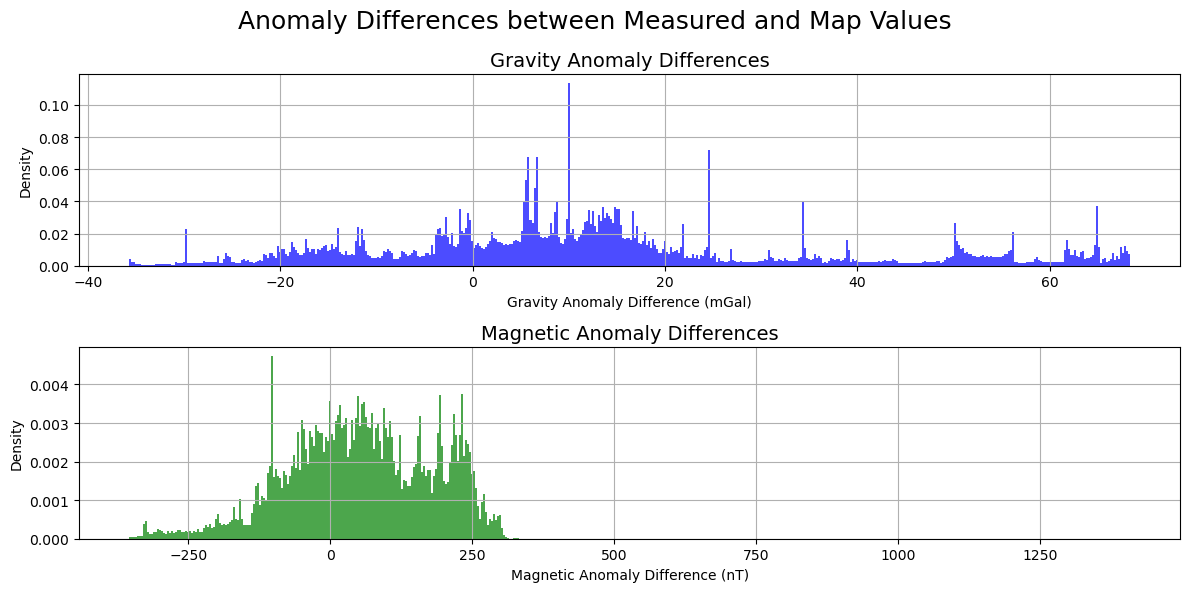

In [106]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), layout="tight")
ax[0].hist(grav_diffs, bins=500, density=True, alpha=0.7, color='blue')
ax[0].set_xlabel('Gravity Anomaly Difference (mGal)')
ax[0].set_ylabel('Density')
ax[0].set_title('Gravity Anomaly Differences', fontsize=14)
ax[0].grid()

ax[1].hist(mag_diffs, bins=500, density=True, alpha=0.7, color='green')
ax[1].set_xlabel('Magnetic Anomaly Difference (nT)')
ax[1].set_ylabel('Density')
ax[1].set_title('Magnetic Anomaly Differences', fontsize=14)
ax[1].grid()
fig.suptitle('Anomaly Differences between Measured and Map Values', fontsize=18)
plt.show()


In [107]:
grav_mean = np.nanmean(grav_diffs)
grav_std = np.nanstd(grav_diffs)
mag_mean = np.nanmean(mag_diffs)
mag_std = np.nanstd(mag_diffs)

print(f"Gravity Anomaly Differences: Mean = {grav_mean:.2f} mGal, Std = {grav_std:.2f} mGal")
print(f"Magnetic Anomaly Differences: Mean = {mag_mean:.2f} nT, Std = {mag_std:.2f} nT")

Gravity Anomaly Differences: Mean = 13.21 mGal, Std = 22.91 mGal
Magnetic Anomaly Differences: Mean = 54.19 nT, Std = 129.06 nT


In [ ]:
!pixi run cargo build --workspace --release

Next we'll setup the output directory for saving off results.

## Geo-navigation simulation

In [11]:
from subprocess import run
import numpy as np

geo_type = "gravity"
mu = 13.21  # mGal
sigma = 22.91  # mGal

# geo_type = "magnetic"
# mu = 54.19
# sigma = 129.06

In [5]:
ROOT.joinpath("pf", geo_type).mkdir(parents=True, exist_ok=True)
ROOT.joinpath("pf", geo_type, "images").mkdir(parents=True, exist_ok=True)

In [110]:
file_list = ROOT.parents[1].joinpath("data", "input").glob("*.csv")

for file in file_list:
    print(f"Processing {file.name}")
    truth = run([find_strapdown_bin(), 
            "-i", ROOT.parents[1].joinpath("data", "input", f"{file}"), 
            "-o", ROOT.joinpath("pf" , geo_type, f"{file.stem}_truth.csv"), "closed-loop",
            "--sched", "passthrough",
            "--fault", "none",
            "--seed", "42"], check=False)
    if truth.returncode != 0:
        print(f"Error processing truth configuration for {file}")
        continue
    degraded = run([find_strapdown_bin(), 
            "-i", ROOT.parents[1].joinpath("data", "input", f"{file}"), 
            "-o", ROOT.joinpath("pf", geo_type, f"{file.stem}_degraded.csv"), "closed-loop",
            #"--sched", "passthrough",
            "--sched", "fixed", "--interval-s", "60",
            "--fault", "degraded", "--rho-pos", "0.99", "--sigma-pos-m", "5", "--rho-vel", "0.95", "--sigma-vel-mps", "5", "--r-scale", "5",
            "--seed", "42"], check=False)
    if degraded.returncode != 0:
        print(f"Error processing degraded configuration for {file}")
        continue
    geonav = run([find_geonav_bin(), 
            "-i", ROOT.parents[1].joinpath("data", "input", f"{file}"), 
            "-o", ROOT.joinpath("pf", geo_type, f"{file.stem}_geo.csv"),
            "--filter-mode", "pf",
            "--geo-type", geo_type,
            "--geo-bias", f"{mu}",
            "--geo-noise-std", f"{sigma}",
            "--geo-frequency-s", f"{60}",
            "--sched", "fixed", "--interval-s", "60",
            "--fault", "degraded", "--rho-pos", "0.99", "--sigma-pos-m", "5", "--rho-vel", "0.95", "--sigma-vel-mps", "5", "--r-scale", "5",
            #"--fault", "none",
        "--seed", "42"], check=False)
    if geonav.returncode != 0:
        print(f"Error processing geonav configuration for {file}")
        continue

Processing 2025-06-18_15-09-25.csv
Read 5343 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25.csv
Processing data 99.99%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-18_15-09-25_truth.csv
Read 5343 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-18_15-09-25_degraded.csv
Read 5343 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25_magnetic.nc
Loaded Magnetic 02m map with 273 x 543 grid points
Built event stream with 10862 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 1.10%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25.csv
Processing 2025-06-14_21-17-02.csv
Read 587 records from /home/james/Code/strapdown-rs/data/input/2025-06-14_21-17-02.csv
Processing data 99.54%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-14_21-17-02_truth.csv
Read 587 records from /home/james/Code/strapdown-rs/data/input/2025-06-14_21-17-02.csv
Processing data 99.74%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-14_21-17-02_degraded.csv
Read 587 records from /home/james/Code/strapdown-rs/data/input/2025-06-14_21-17-02.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-06-14_21-17-02_magnetic.nc
Loaded Magnetic 02m map with 11 x 22 grid points
Built event stream with 1183 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 20.29%...Erro


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Processing data 99.94%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2023-08-09_124742_truth.csv
Read 5210 records from /home/james/Code/strapdown-rs/data/input/2023-08-09_124742.csv
Processing data 0.10%...Read 5210 records from /home/james/Code/strapdown-rs/data/input/2023-08-09_124742.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2023-08-09_124742_magnetic.nc
Loaded Magnetic 02m map with 68 x 79 grid points
Built event stream with 10591 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.66%...

Error running closed-loop simulation: Longitude out of range: -22615.861783620243

thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main


Processing data 1.13%...Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2023-08-09_124742.csv
Processing 2025-07-08_14-12-53.csv
Read 6660 records from /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv
Processing data 3.02%...

note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-07-08_14-12-53_truth.csv
Read 6660 records from /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv
Processing data 39.17%...Read 6660 records from /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53_magnetic.nc
Loaded Magnetic 02m map with 45 x 424 grid points
Built event stream with 13158 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.08%...

Error running closed-loop simulation: Altitude out of range: -12522.242973644286 m


Processing data 0.84%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv
Processing 2025-07-31_23-36-03.csv
Read 13450 records from /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-07-31_23-36-03_truth.csv
Read 13450 records from /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03.csv
Processing data 99.99%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-07-31_23-36-03_degraded.csv
Read 13450 records from /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03_magnetic.nc
Loaded Magnetic 02m map with 403 x 1131 grid points
Built event stream with 27348 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.4


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03.csv
Processing 2024-06-20_165550.csv
Read 8413 records from /home/james/Code/strapdown-rs/data/input/2024-06-20_165550.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2024-06-20_165550_truth.csv
Read 8413 records from /home/james/Code/strapdown-rs/data/input/2024-06-20_165550.csv
Processing data 19.16%...Read 8413 records from /home/james/Code/strapdown-rs/data/input/2024-06-20_165550.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2024-06-20_165550_magnetic.nc
Loaded Magnetic 02m map with 542 x 369 grid points
Built event stream with 17106 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.06%...

Error running closed-loop simulation: Altitude out of range: -471632.41707992554 m


Processing data 0.70%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2024-06-20_165550.csv
Processing 2025-03-01_150426.csv
Read 5450 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_150426.csv
Processing data 99.94%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-03-01_150426_truth.csv
Read 5450 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_150426.csv
Processing data 99.92%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-03-01_150426_degraded.csv
Read 5450 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_150426.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-03-01_150426_magnetic.nc
Loaded Magnetic 02m map with 145 x 405 grid points
Built event stream with 11080 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 1.08%...Error processin


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Read 17817 records from /home/james/Code/strapdown-rs/data/input/2025-06-27_11-54-35.csv
Processing data 99.99%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-27_11-54-35_truth.csv
Read 17817 records from /home/james/Code/strapdown-rs/data/input/2025-06-27_11-54-35.csv
Processing data 99.97%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-27_11-54-35_degraded.csv
Read 17817 records from /home/james/Code/strapdown-rs/data/input/2025-06-27_11-54-35.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-06-27_11-54-35_magnetic.nc
Loaded Magnetic 02m map with 832 x 1339 grid points
Built event stream with 35097 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.34%...Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-06-27_11-54-35.csv
Processing 2025-07-04_17-24-46


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Read 6271 records from /home/james/Code/strapdown-rs/data/input/2025-07-04_17-24-46.csv
Processing data 99.97%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-07-04_17-24-46_truth.csv
Read 6271 records from /home/james/Code/strapdown-rs/data/input/2025-07-04_17-24-46.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-07-04_17-24-46_degraded.csv
Read 6271 records from /home/james/Code/strapdown-rs/data/input/2025-07-04_17-24-46.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-07-04_17-24-46_magnetic.nc
Loaded Magnetic 02m map with 373 x 285 grid points
Built event stream with 12748 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.94%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-07-04_17-24-46.csv
Processing 2023-08-06_144805.csv
Read 8922 records from /home/james/Code/strapdown-rs/data/input/2023-08-06_144805.csv
Processing data 99.99%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2023-08-06_144805_truth.csv
Read 8922 records from /home/james/Code/strapdown-rs/data/input/2023-08-06_144805.csv
Processing data 58.03%...Read 8922 records from /home/james/Code/strapdown-rs/data/input/2023-08-06_144805.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2023-08-06_144805_magnetic.nc
Loaded Magnetic 02m map with 480 x 151 grid points
Built event stream with 18140 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.22%...

Error running closed-loop simulation: Altitude out of range: -9572.884221859276 m


Processing data 0.66%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2023-08-06_144805.csv
Processing 2025-03-01_164639.csv
Read 5367 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_164639.csv
Processing data 99.96%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-03-01_164639_truth.csv
Read 5367 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_164639.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-03-01_164639_degraded.csv
Read 5367 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_164639.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-03-01_164639_magnetic.nc
Loaded Magnetic 02m map with 145 x 405 grid points
Built event stream with 10912 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 1.10%...Error processin


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Read 7917 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_16-52-32.csv
Processing data 99.97%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-18_16-52-32_truth.csv
Read 7917 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_16-52-32.csv
Processing data 99.97%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-18_16-52-32_degraded.csv
Read 7917 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_16-52-32.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-06-18_16-52-32_magnetic.nc
Loaded Magnetic 02m map with 326 x 369 grid points
Built event stream with 16096 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.75%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-06-18_16-52-32.csv
Processing 2025-08-03_18-15-59.csv
Read 14900 records from /home/james/Code/strapdown-rs/data/input/2025-08-03_18-15-59.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-08-03_18-15-59_truth.csv
Read 14900 records from /home/james/Code/strapdown-rs/data/input/2025-08-03_18-15-59.csv
Processing data 44.20%...Read 14900 records from /home/james/Code/strapdown-rs/data/input/2025-08-03_18-15-59.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-08-03_18-15-59_magnetic.nc
Loaded Magnetic 02m map with 391 x 1097 grid points
Built event stream with 30296 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.07%...

Error running closed-loop simulation: Altitude out of range: -13590.819028429687 m


Processing data 0.40%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-08-03_18-15-59.csv
Processing 2025-06-11_20-34-24.csv
Read 1648 records from /home/james/Code/strapdown-rs/data/input/2025-06-11_20-34-24.csv
Processing data 99.76%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-11_20-34-24_truth.csv
Read 1648 records from /home/james/Code/strapdown-rs/data/input/2025-06-11_20-34-24.csv
Processing data 99.24%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-06-11_20-34-24_degraded.csv
Read 1648 records from /home/james/Code/strapdown-rs/data/input/2025-06-11_20-34-24.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-06-11_20-34-24_magnetic.nc
Loaded Magnetic 02m map with 23 x 32 grid points
Built event stream with 925 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 12.97%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-06-11_20-34-24.csv
Processing 2023-08-04_214758.csv
Read 8811 records from /home/james/Code/strapdown-rs/data/input/2023-08-04_214758.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2023-08-04_214758_truth.csv
Read 8811 records from /home/james/Code/strapdown-rs/data/input/2023-08-04_214758.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2023-08-04_214758_degraded.csv
Read 8811 records from /home/james/Code/strapdown-rs/data/input/2023-08-04_214758.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2023-08-04_214758_magnetic.nc
Loaded Magnetic 02m map with 448 x 172 grid points
Built event stream with 17900 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 0.67%...


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2023-08-04_214758.csv
Processing 2023-08-09_163741.csv
Read 2581 records from /home/james/Code/strapdown-rs/data/input/2023-08-09_163741.csv
Processing data 99.90%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2023-08-09_163741_truth.csv
Read 2581 records from /home/james/Code/strapdown-rs/data/input/2023-08-09_163741.csv
Processing data 99.96%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2023-08-09_163741_degraded.csv
Read 2581 records from /home/james/Code/strapdown-rs/data/input/2023-08-09_163741.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2023-08-09_163741_magnetic.nc
Loaded Magnetic 02m map with 72 x 103 grid points
Built event stream with 5246 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 2.29%...Error processing 


thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Processing data 99.95%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-07-18_23-13-43_truth.csv
Read 5563 records from /home/james/Code/strapdown-rs/data/input/2025-07-18_23-13-43.csv
Processing data 99.95%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/pf/magnetic/2025-07-18_23-13-43_degraded.csv
Read 5563 records from /home/james/Code/strapdown-rs/data/input/2025-07-18_23-13-43.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-07-18_23-13-43_magnetic.nc
Loaded Magnetic 02m map with 458 x 193 grid points
Built event stream with 11309 events
Running geophysical navigation simulation...
Initialized Particle Filter with 1000 particles
Processing data 1.06%...Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-07-18_23-13-43.csv



thread 'main' panicked at geonav/src/lib.rs:544:10:
Failed to create GeomagneticField: HeightOutsideOfValidityRange { min_height_km: -1.0, max_height_km: 850.0 }
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::result::unwrap_failed
   3: <geonav::MagneticAnomalyMeasurement as geonav::GeophysicalAnomalyMeasurementModel>::get_anomaly
   4: geonav::geo_particle_filter_loop
   5: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


## Error processing

In [7]:
import pandas as pd
from haversine import haversine_vector, Unit


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2025-06-18_15-09-25.png
Error reading geophysical INS file for /home/james/Code/strapdown-rs/data/input/2025-06-14_21-17-02.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/2025-06-14_21-17-02_geo.csv'
Error reading degraded file for /home/james/Code/strapdown-rs/data/input/2023-08-09_124742.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/2023-08-09_124742_degraded.csv'
Error reading degraded file for /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/2025-07-08_14-12-53_degraded.csv'


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2025-07-31_23-36-03.png
Error reading degraded file for /home/james/Code/strapdown-rs/data/input/2024-06-20_165550.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/2024-06-20_165550_degraded.csv'


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2025-03-01_150426.png


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2025-06-27_11-54-35.png


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2025-07-04_17-24-46.png
Error reading degraded file for /home/james/Code/strapdown-rs/data/input/2023-08-06_144805.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/2023-08-06_144805_degraded.csv'


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2025-03-01_164639.png


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2025-06-18_16-52-32.png
Error reading degraded file for /home/james/Code/strapdown-rs/data/input/2025-08-03_18-15-59.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/2025-08-03_18-15-59_degraded.csv'
Error calculating haversine distances for /home/james/Code/strapdown-rs/data/input/2025-06-11_20-34-24.csv: When not in combination mode, arrays must be of same size. If mode is required, use comb=True as argument.


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2023-08-04_214758.png


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2023-08-09_163741.png


/tmp/ipykernel_24570/611789129.py:62: RuntimeWarning: divide by zero encountered in divide
  deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:63: RuntimeWarning: divide by zero encountered in divide
  geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))
/tmp/ipykernel_24570/611789129.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  geo_rmse - deg_rmse,                # rmse difference
/tmp/ipykernel_24570/611789129.py:75: RuntimeWarning: invalid value encountered in scalar subtract
  (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
/tmp/ipykernel_24570/611789129.py:96: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
/tmp/ipykernel_24570/611789129.py:97: RuntimeWarning: divide by zero encountered in divide
  ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_d

Writing image to /home/james/Code/strapdown-rs/examples/geonav-sim/ukf/gravity/images/2025-07-18_23-13-43.png


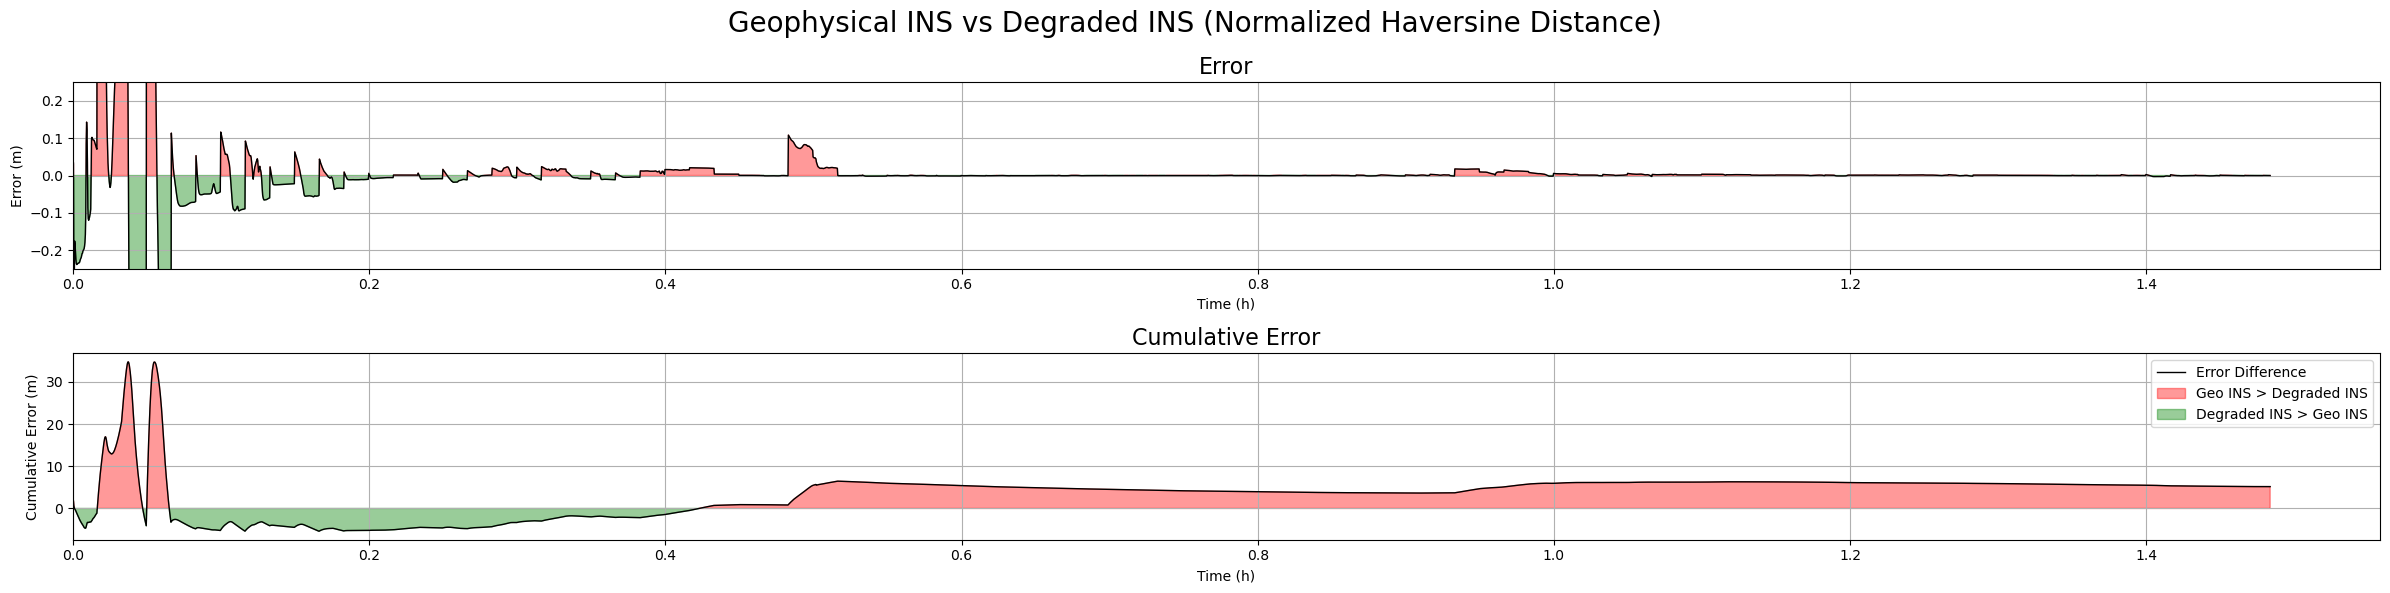

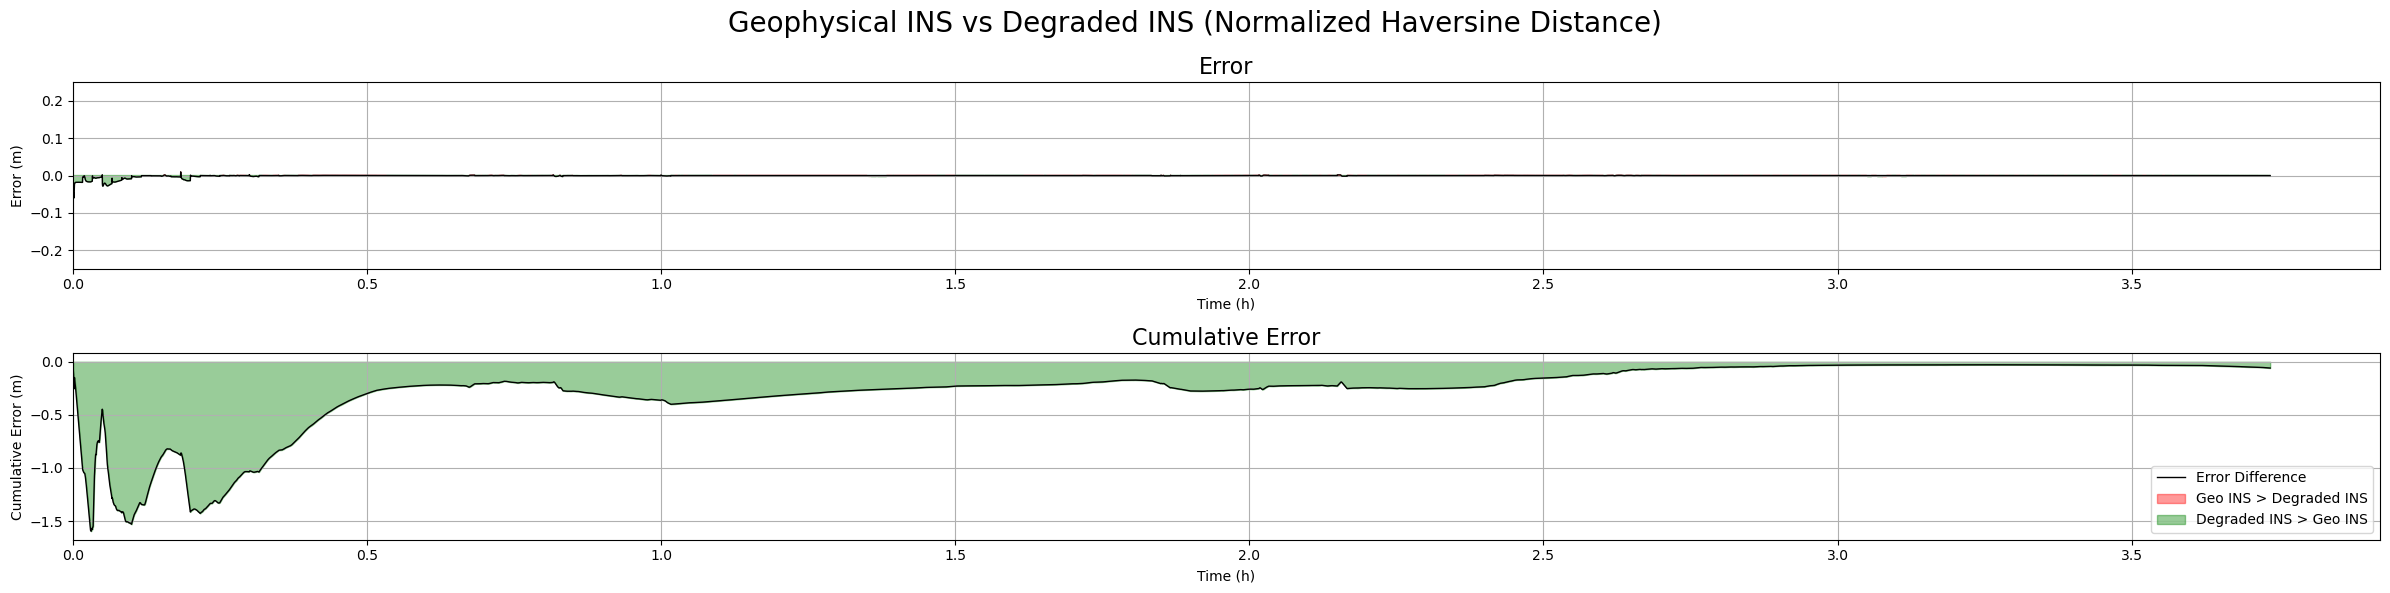

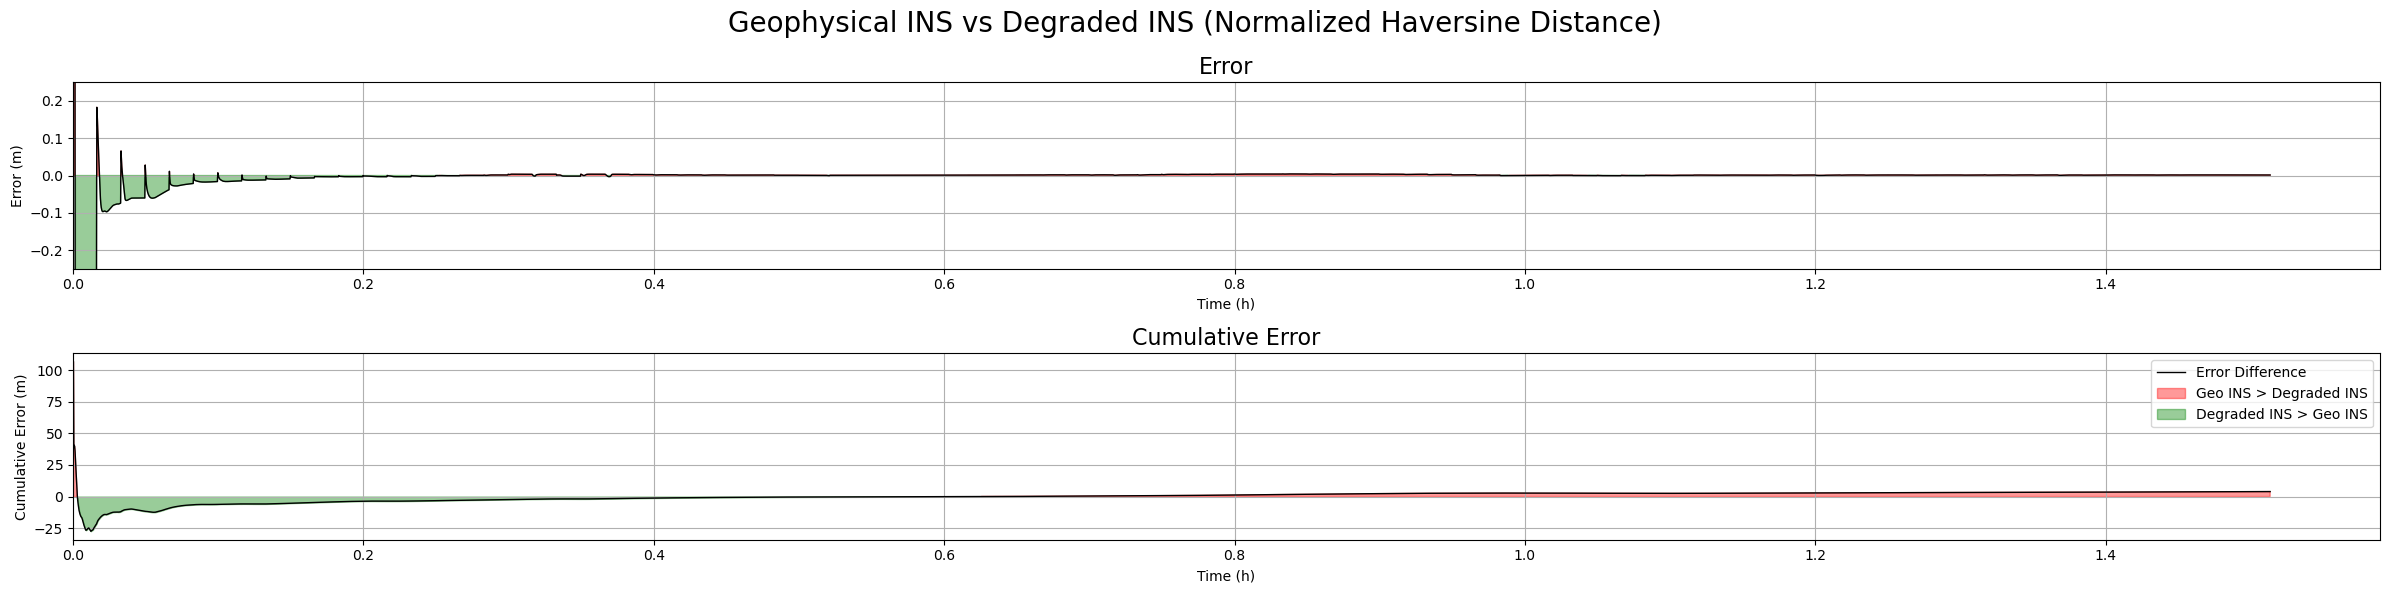

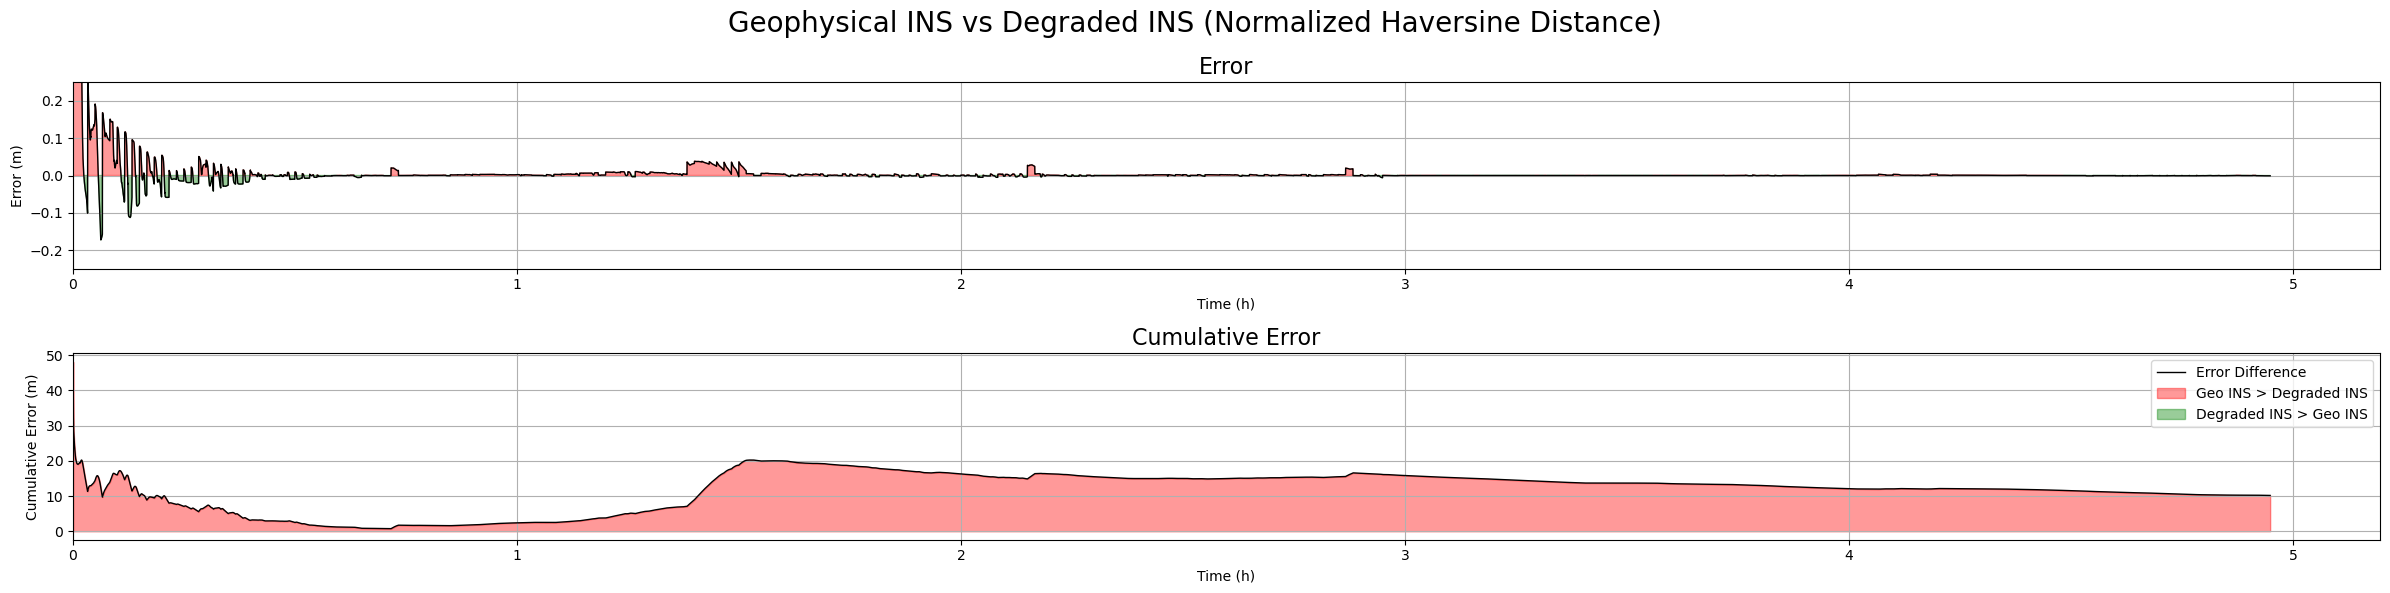

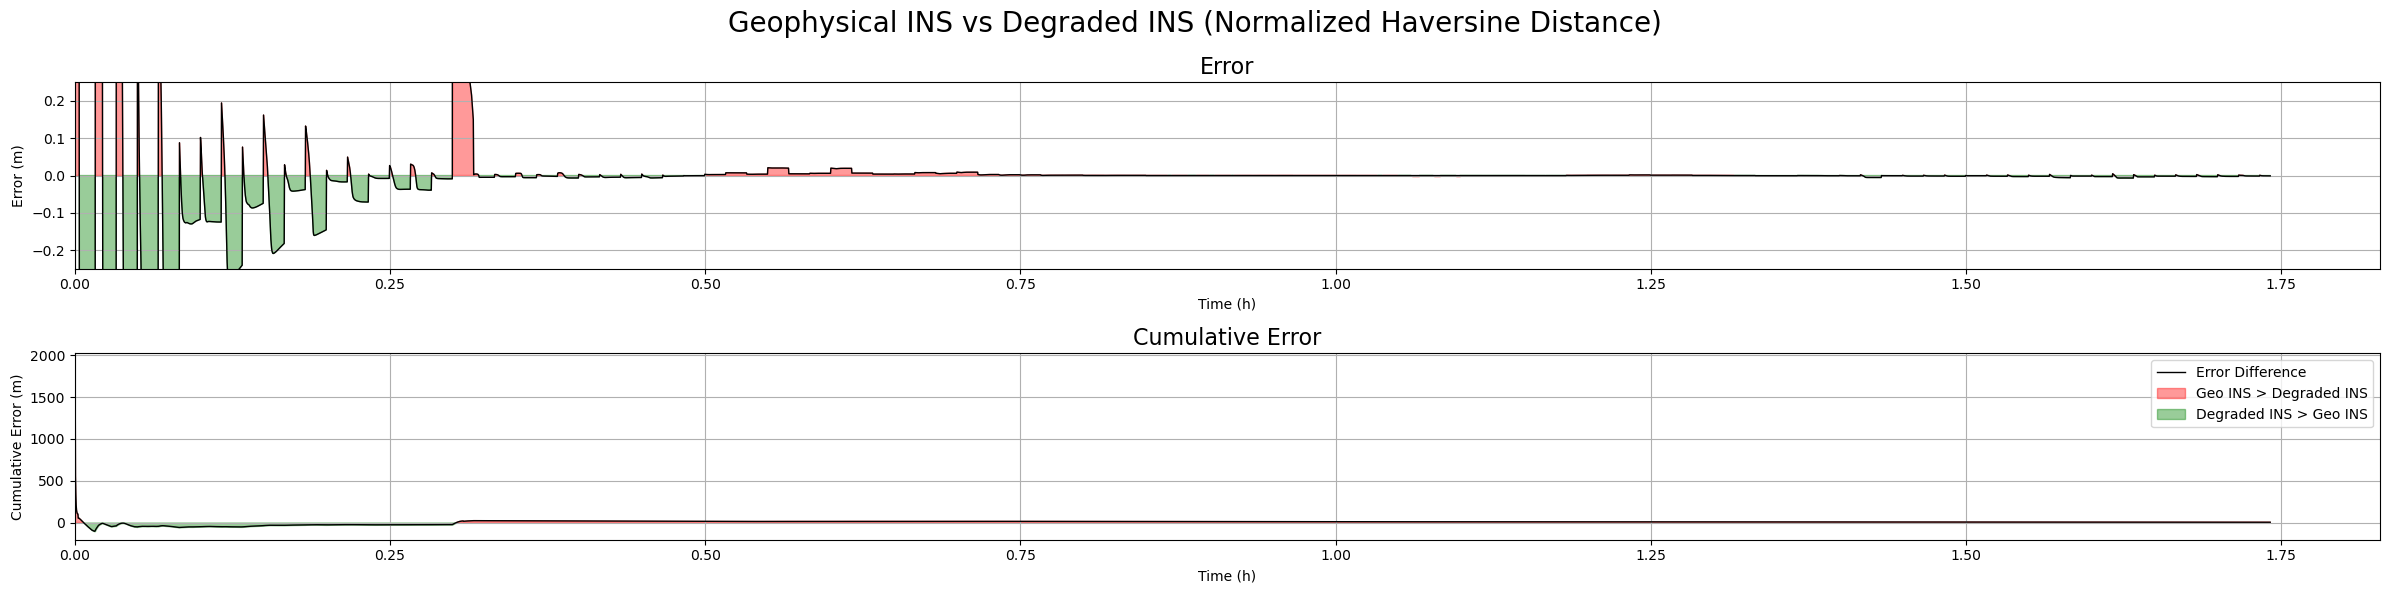

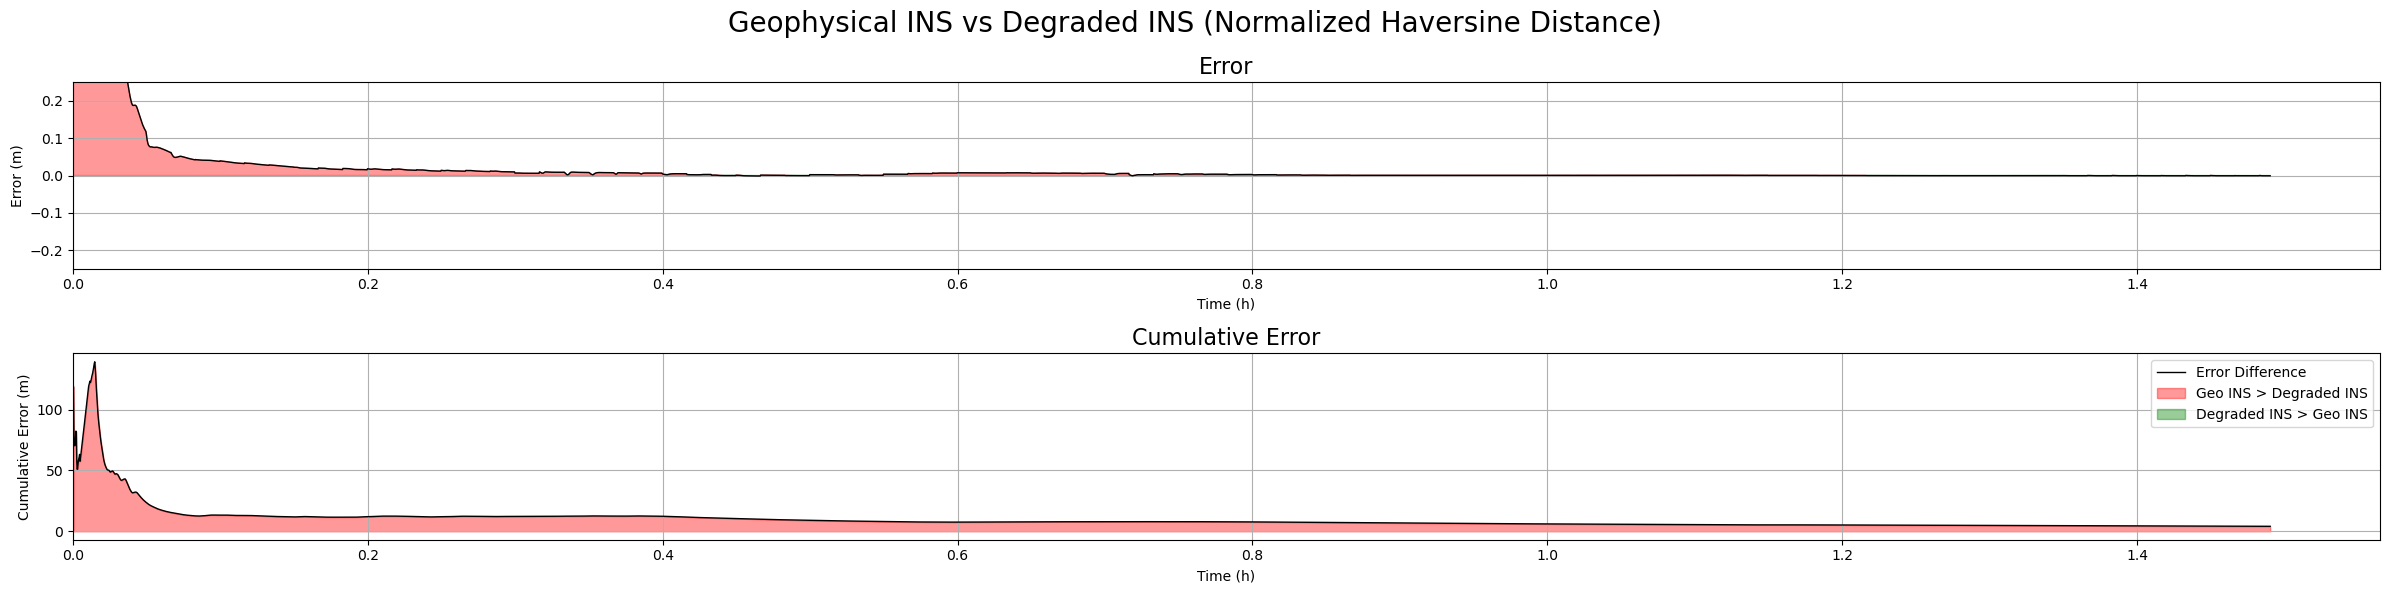

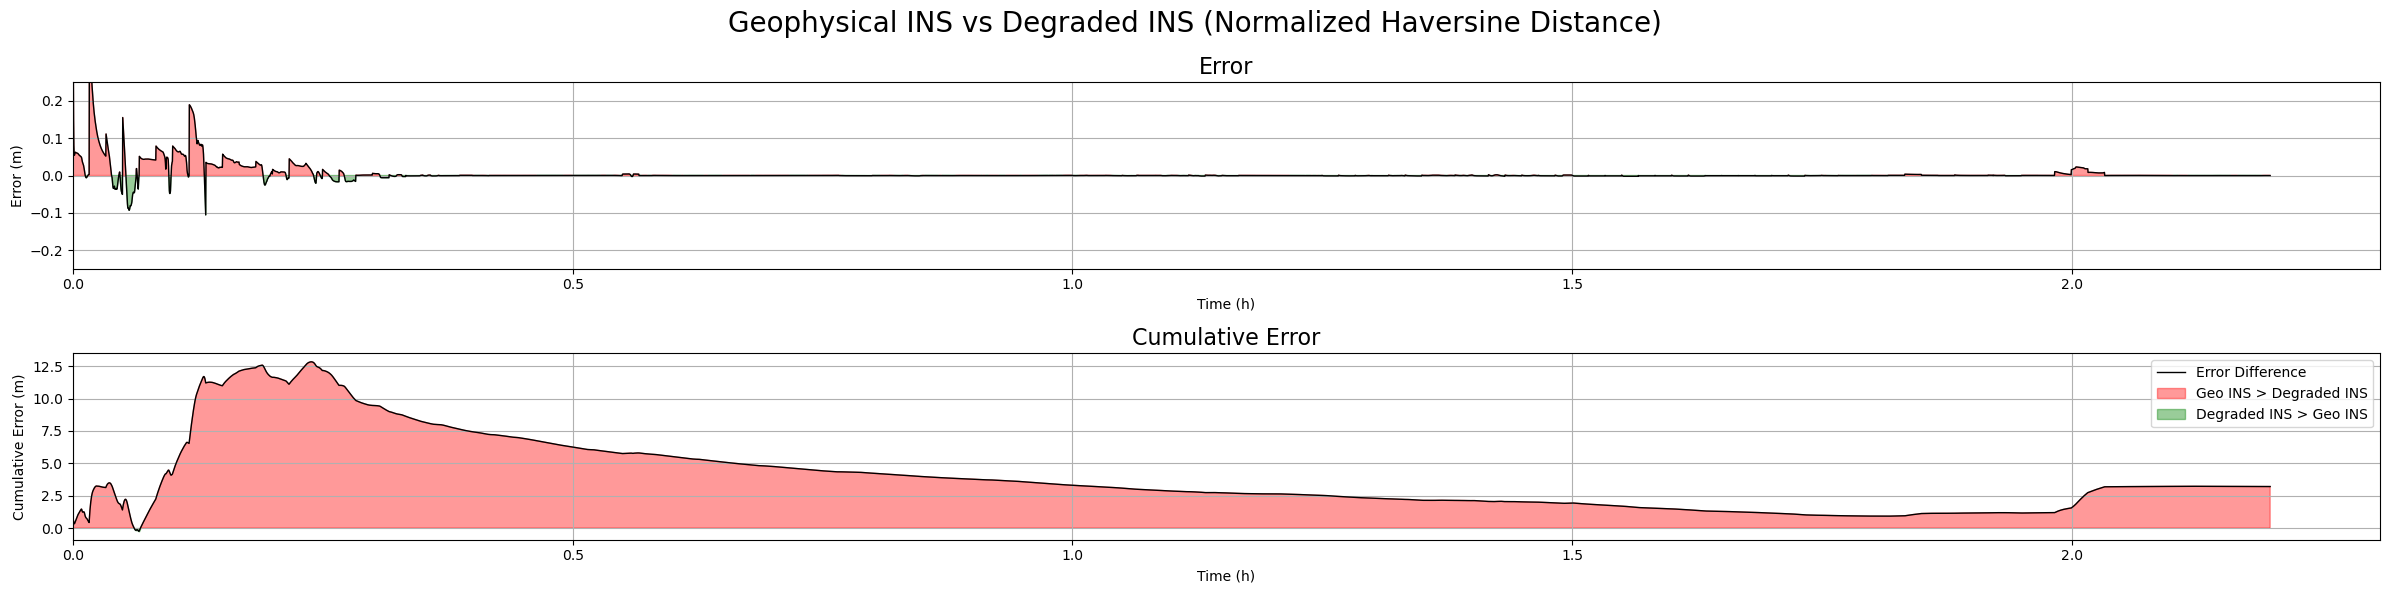

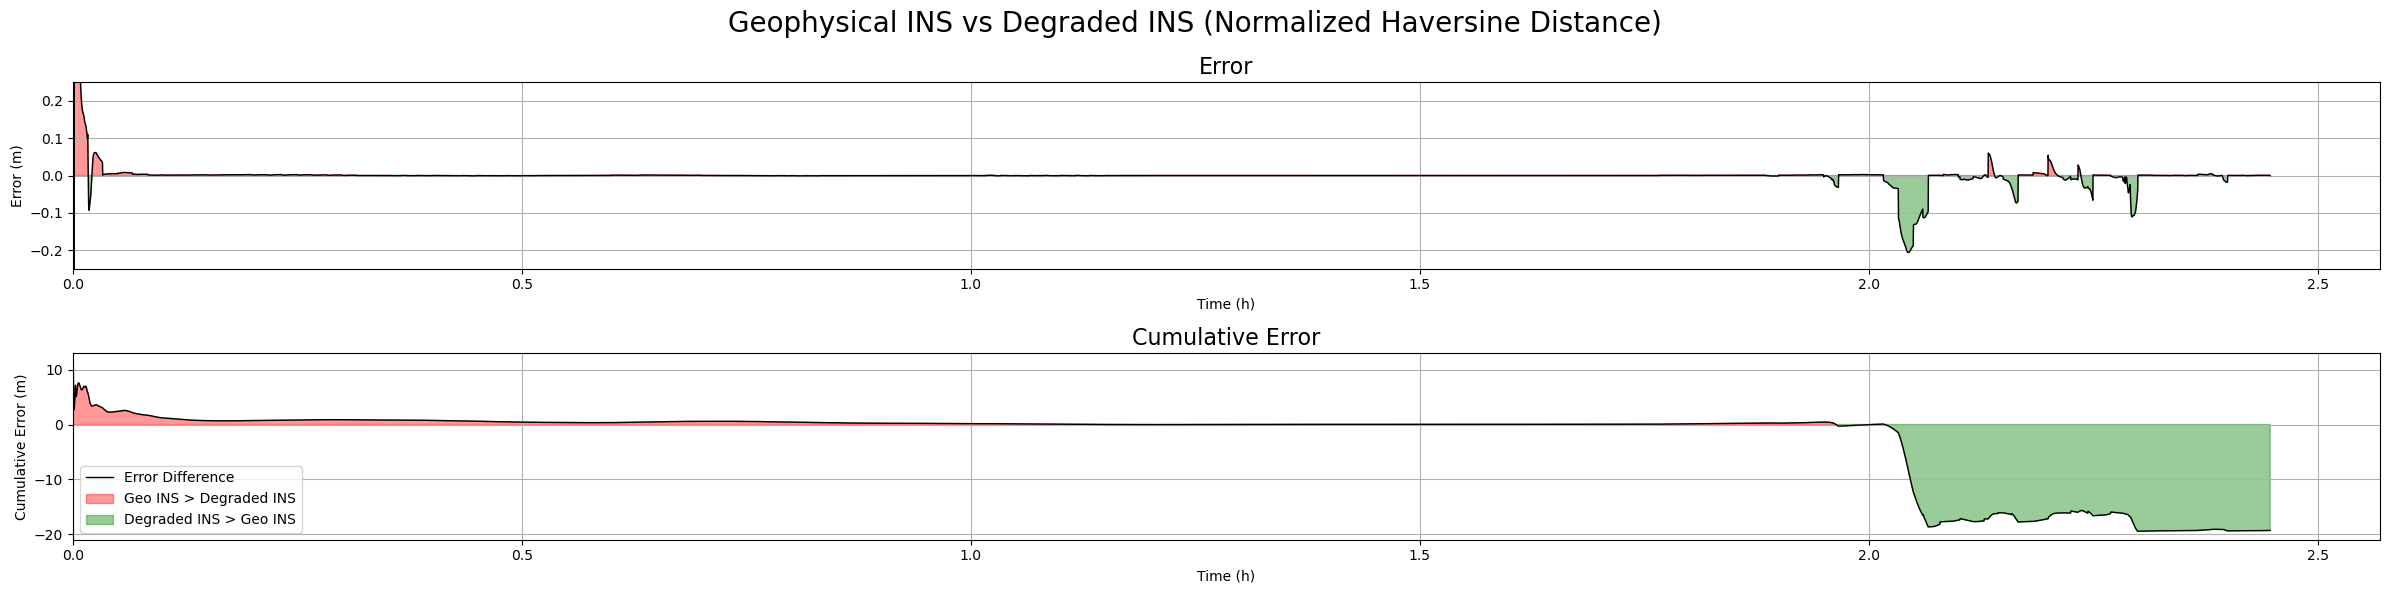

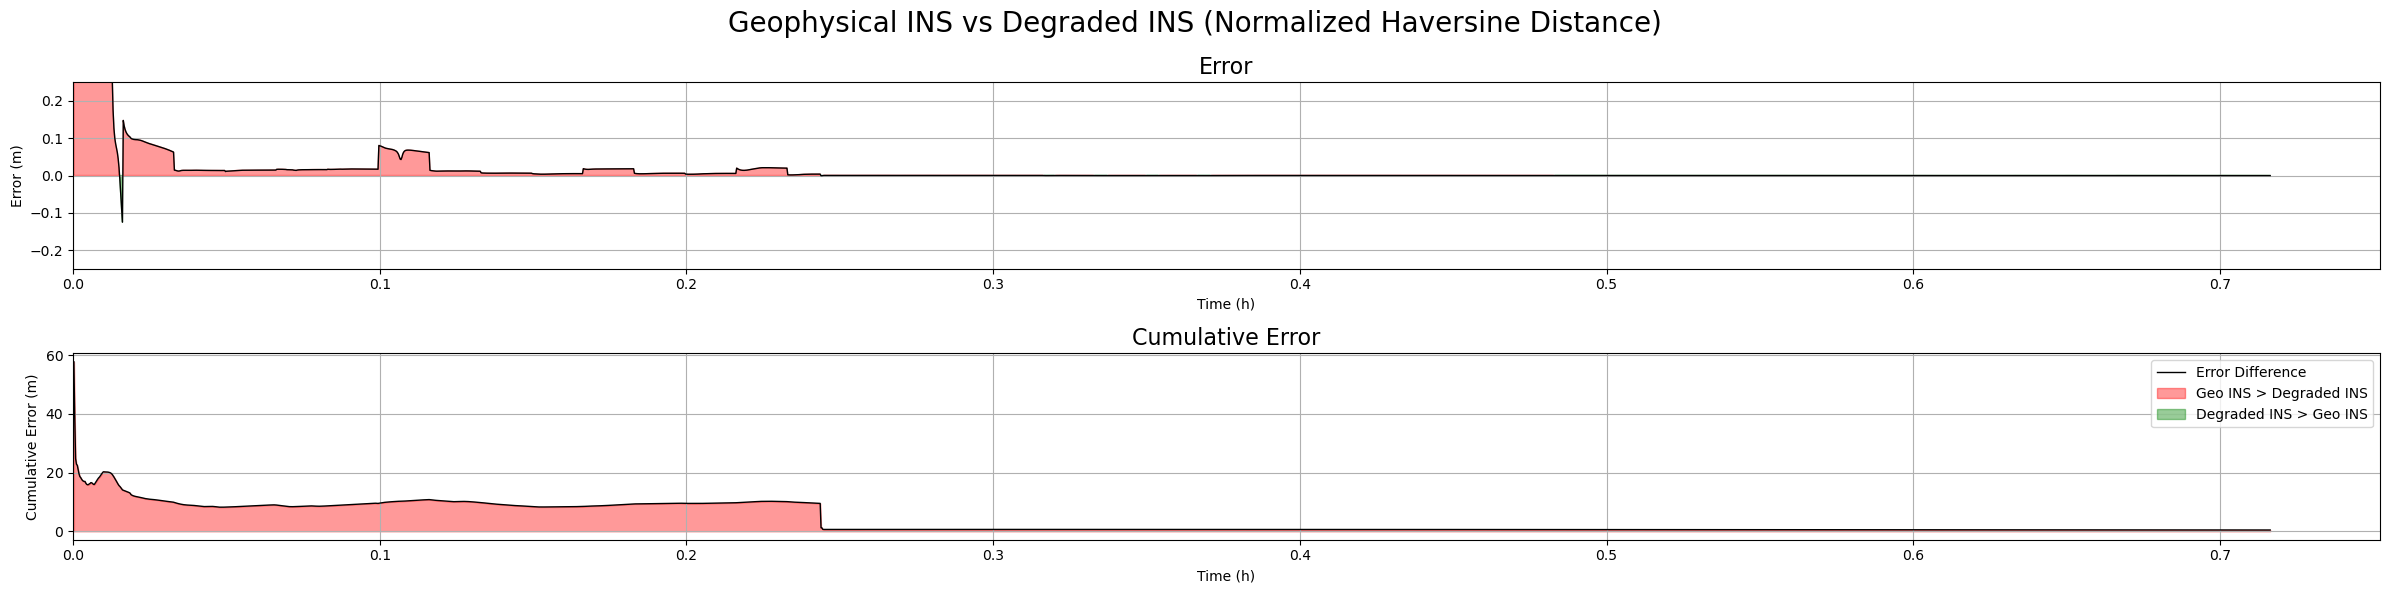

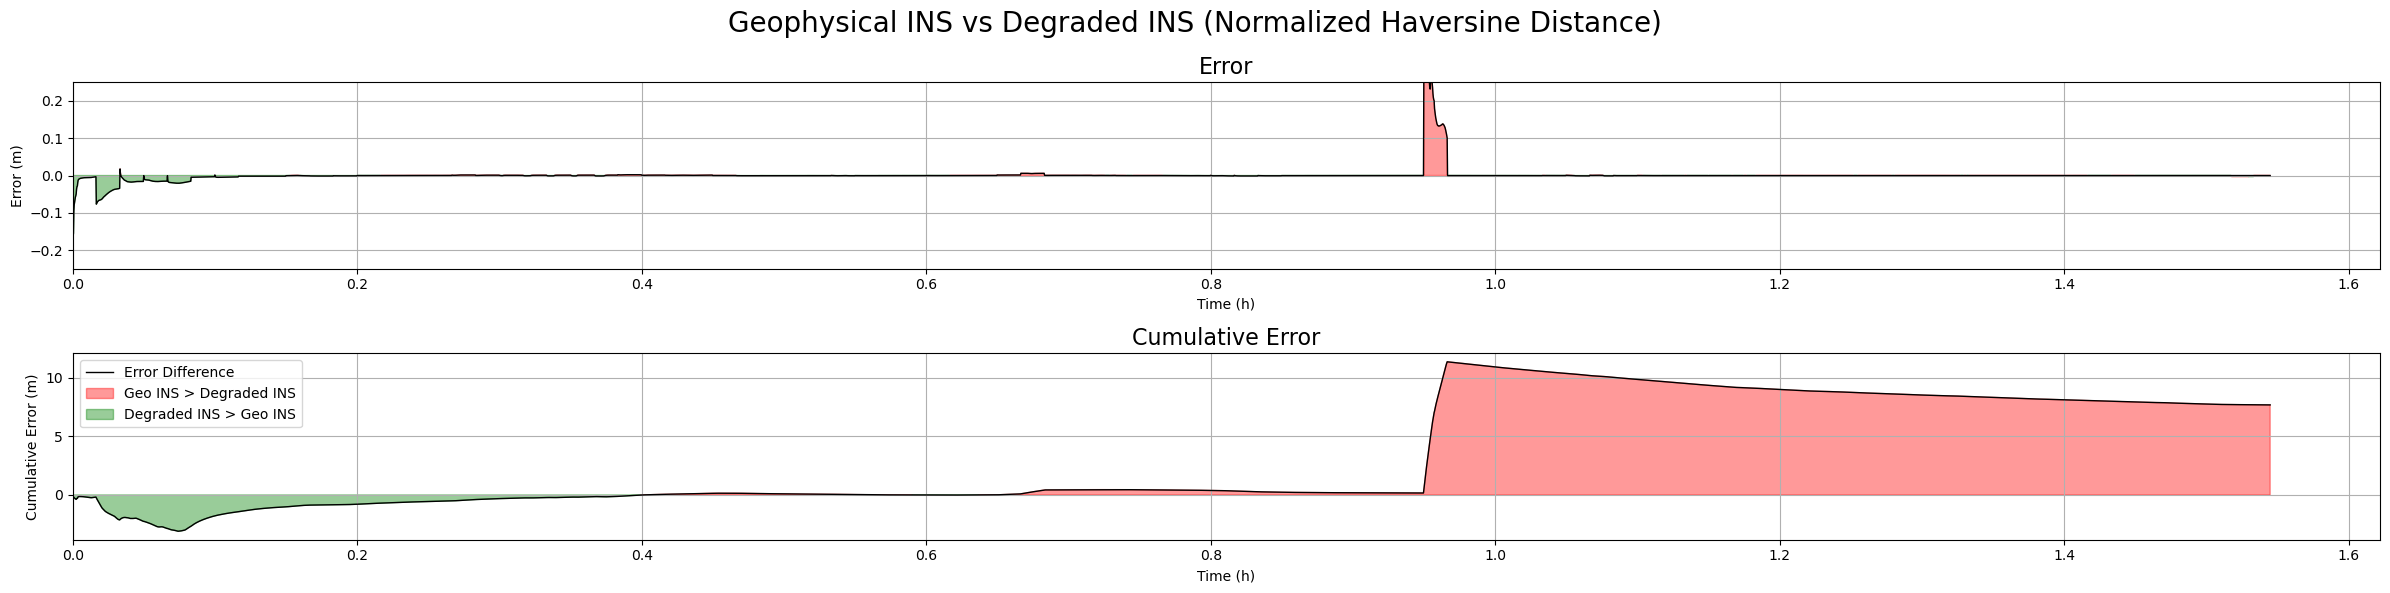

In [12]:
mode = "ukf"

# Gives the statistics of the error differences between geophysical INS and degraded INS
statistics_err = pd.DataFrame(columns=['rmse', 'max', 'min', 'mean', 'std', 'median', '95th', '5th', 'drift'])
statistics_cum = pd.DataFrame(columns=['rmse', 'max', 'min', 'mean', 'std', 'median', '95th', '5th', 'drift'])

file_list = ROOT.parents[1].joinpath("data", "input").glob("*.csv")

for file in file_list:
    try:
        gps = pd.read_csv(ROOT.parents[1].joinpath("data", "input" ,f"{file}"), index_col=0, parse_dates=True)
    except FileNotFoundError as e:
        print(f"Error reading GPS file {file}: {e}")
        continue
    try:
        nav = pd.read_csv(ROOT.joinpath(mode, geo_type, f"{file.stem}_truth.csv"), index_col=0, parse_dates=True)
    except FileNotFoundError as e:
        print(f"Error reading truth file for {file}: {e}")
        continue
    try:
        deg = pd.read_csv(ROOT.joinpath(mode, geo_type, f"{file.stem}_degraded.csv"), index_col=0, parse_dates=True)
    except FileNotFoundError as e:
        print(f"Error reading degraded file for {file}: {e}")
        continue
    try:
        geo = pd.read_csv(ROOT.joinpath(mode, geo_type, f"{file.stem}_geo.csv"), index_col=0, parse_dates=True)
    except FileNotFoundError as e:
        print(f"Error reading geophysical INS file for {file}: {e}")
        continue
    try:
        distance_traveled = haversine_vector(nav[["latitude", "longitude"]].to_numpy()[:-1, :], 
                                                  nav[["latitude", "longitude"]].to_numpy()[1:, :], 
                                                  Unit.METERS)
        distance_traveled = np.nancumsum(distance_traveled)
        geo_error = haversine_vector(geo[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), 
                                          nav[["latitude", "longitude"]].to_numpy(), 
                                          Unit.METERS)

        deg_error = haversine_vector(deg[["latitude", "longitude"]].to_numpy(), 
                                          nav[["latitude", "longitude"]].to_numpy(), 
                                          Unit.METERS)

        nav_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), 
                                          gps[["latitude", "longitude"]].to_numpy()[1:, :], 
                                          Unit.METERS)
    except Exception as e:
        print(f"Error calculating haversine distances for {file}: {e}")
        continue

    time = (nav.index - nav.index[0]).total_seconds() / 3600
    distance_traveled = np.insert(distance_traveled, 0, 0)

    geo_cum_error = np.cumsum(geo_error)
    deg_cum_error = np.cumsum(deg_error)
    
    root_mean_geo_cum_error = np.sqrt(np.cumsum(geo_error**2) / time) # / distance_traveled
    root_mean_deg_cum_error = np.sqrt(np.cumsum(deg_error**2) / time) # / distance_traveled

    err_diff = geo_error - deg_error 
    cum_err_diff = np.cumsum(err_diff) #geo_cum_error - deg_cum_error 

    deg_rmse = np.sqrt(np.nanmean((deg_error / distance_traveled)**2))
    geo_rmse = np.sqrt(np.nanmean((geo_error / distance_traveled)**2))

    # Statistics calculation
    statistics_err.loc[file.stem] = [
        geo_rmse - deg_rmse,                # rmse difference
        np.nanmax(err_diff),                # max
        np.nanmin(err_diff),                # min
        np.nanmean(err_diff),               # mean
        np.nanstd(err_diff),                # std
        np.nanmedian(err_diff),             # median
        np.nanpercentile(err_diff, 95),     # 95th percentile
        np.nanpercentile(err_diff, 5),      # 5th percentile
        (geo_rmse - deg_rmse) / time[-1]    # drift rate difference
    ]
    statistics_cum.loc[file.stem] = [
        (root_mean_geo_cum_error[-1] - root_mean_deg_cum_error[-1]) / time[-1],  # rmse
        np.nanmax(cum_err_diff),                            # max
        np.nanmin(cum_err_diff),                            # min
        np.nanmean(cum_err_diff),                           # mean
        np.nanstd(cum_err_diff),                            # std
        np.nanmedian(cum_err_diff),                         # median
        np.nanpercentile(cum_err_diff, 95),                 # 95th percentile
        np.nanpercentile(cum_err_diff, 5),                  # 5th percentile
        (geo_cum_error[-1] - deg_cum_error[-1]) / time[-1]          # drift rate
    ]

    # Drift rates
    err_diff_rate = np.cumsum(err_diff) / time[-1]
    # rmse_drift = np.cumsum(root_mean_err_diff) / time[-1]
    cum_drift = np.cumsum(cum_err_diff) / time[-1]

    # General errors
    fig, ax = plt.subplots(2, 1, figsize=(24, 6), layout="tight")
    ax[0].plot(time,         err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
    ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_diff > 0, alpha=0.4, color="red", label="Geo INS > Degraded INS")
    ax[0].fill_between(time, err_diff / distance_traveled, 0, where=err_diff < 0, alpha=0.4, color="green", label="Degraded INS > Geo INS")
    ax[0].set_xlim(left=0)
    ax[0].set_ylim((-0.25, 0.25))
    ax[0].set_xlabel('Time (h)')
    ax[0].set_ylabel('Error (m)')
    ax[0].set_title('Error', fontsize=16)
    ax[0].grid()
    # ax[0].legend()
    #fig.savefig(ROOT.joinpath(mode, geo_type, "images", f"{file.stem}_error.png"), dpi=300)

    # Cumulative errors
    #fig, ax = plt.subplots(1, 1, figsize=(24, 6), layout="tight")
    # Cumulative errors
    # ax.plot(time, geo_cum_error, label="Geophysical INS", color="blue", linewidth=2)
    # ax.plot(time, deg_cum_error, label="Degraded INS", color="orange", linewidth=2)
    ax[1].plot(time,         cum_err_diff / distance_traveled, label="Error Difference", color="black", linewidth=1)
    ax[1].fill_between(time, cum_err_diff / distance_traveled, 0, where=cum_err_diff > 0, alpha=0.4, color="red", label="Geo INS > Degraded INS")
    ax[1].fill_between(time, cum_err_diff / distance_traveled, 0, where=cum_err_diff < 0, alpha=0.4, color="green", label="Degraded INS > Geo INS")
    ax[1].set_xlim(left=0)
    ax[1].set_xlabel('Time (h)')
    ax[1].set_ylabel('Cumulative Error (m)')
    ax[1].set_title('Cumulative Error', fontsize=16)
    ax[1].grid()
    ax[1].legend()
    fig.suptitle("Geophysical INS vs Degraded INS (Normalized Haversine Distance)", fontsize=20)
    fig.savefig(ROOT.joinpath(mode, geo_type, "images", f"{file.stem}_cum_error.png"), dpi=300) 

    # General error normalized with distance traveled
    # fig, ax = plt.subplots(1, 1, figsize=(24, 6), layout="tight")
    # ax.plot(time, geo_error / distance_traveled, label="Geophysical INS", color="blue", linewidth=2)
    # ax.plot(time, deg_error / distance_traveled, label="Degraded INS", color="orange", linewidth=2)
    # ax.set_xlim(left=0)
    # ax[0].set_ylim((0, 250))
    # ax.set_xlabel('Time (h)')
    # ax.set_ylabel('Error (m)')
    # ax.set_title('2D Haversine Error (Normalized w.r.t. Distance Traveled)', fontsize=16)
    # ax.grid()
    # ax.legend()
    # fig.savefig(ROOT.joinpath(mode, geo_type, "images", f"{file.stem}_error_normalized.png"), dpi=300)

    # Cumulative error normalized with distance traveled
    # fig, ax = plt.subplots(1, 1, figsize=(24, 6), layout="tight")
    # ax.plot(time, geo_cum_error / distance_traveled, label="Geophysical INS", color="blue", linewidth=2)
    # ax.plot(time, deg_cum_error / distance_traveled, label="Degraded INS", color="orange", linewidth=2)
    # ax.set_xlim(left=0)
    # ax[0].set_ylim((0, 250))
    # ax.set_xlabel('Time (h)')
    # ax.set_ylabel('Cumulative Error (m)')
    # ax.set_title('Cumulative 2D Haversine Error (Normalized w.r.t. Distance Traveled)', fontsize=16)
    # ax.grid()
    # ax.legend()
    # fig.savefig(ROOT.joinpath(mode, geo_type, "images", f"{file.stem}_cum_error_normalized.png"), dpi=300)
# 
    # ax[1].plot(time, err, label="GeoNav")
    # ax[1].fill_between(time, err, 0, where=err > 0, alpha=0.2, color="red")
    # ax[1].fill_between(time, err, 0, where=err < 0, alpha=0.2, color="green")
    # ax[1].set_xlim(left=0)
    # #ax[1].set_ylim((-2, 2))
    # ax[1].set_xlabel('Time (h)')
    # ax[1].set_ylabel('Error (m)')
    # ax[1].set_title('Comparative Error (Geophysical INS vs Degraded INS)', fontsize=16)
    # ax[1].grid()

    # fig.suptitle(f"Geophysical INS vs Degraded INS | Error: {geo_error_total - deg_error_total:.2f} m/h", fontsize=20)
    # fig.tight_layout(rect=(0, 0.03, 1, 0.95))
    print(f"Writing image to {ROOT.joinpath(mode, geo_type, "images", f"{file.stem}.png")}")
    # plt.savefig(ROOT.joinpath(mode, geo_type, "images", f"{file.stem}.png"), dpi=300)

In [9]:
statistics_err

,rmse,max,min,mean,std,median,95th,5th,drift
2025-06-18_15-09-25,NaN,15204.878163,-865.492581,737.702319,1758.474308,360.166325,2110.803498,-354.993117,NaN
2025-07-31_23-36-03,NaN,450.233871,-336.260666,8.825728,50.305969,0.895805,94.579674,-41.933988,NaN
2025-03-01_150426,NaN,101.798605,-100.165674,29.364708,44.129664,36.015520,87.117131,-38.666628,NaN
2025-06-27_11-54-35,NaN,14154.315969,-2216.309697,104.074998,864.969334,42.549244,846.874887,-736.255542,NaN
2025-07-04_17-24-46,NaN,25595.905619,-4057.526863,42.126924,1339.667909,-1.056737,259.350758,-502.956715,NaN
2025-03-01_164639,NaN,125.265310,-69.803652,38.153080,43.389898,44.822219,106.270428,-33.802116,NaN
2025-06-18_16-52-32,NaN,2790.741646,-1873.354969,118.312390,362.891042,1.339655,861.064293,-102.910499,NaN
2023-08-04_214758,NaN,49723.368979,-32688.291119,1671.749873,6159.270107,58.769609,12534.065128,-58.943453,NaN
2023-08-09_163741,NaN,27188.653294,-1029.001398,-24.274813,538.892587,-25.218402,9.965712,-80.949600,NaN
2025-07-18_23-13-43,NaN,23960.839373,-122.316723,254.755423,2113.335306,21.154010,182.459143,-44.122672,NaN


In [10]:
statistics_cum

,rmse,max,min,mean,std,median,95th,5th,drift
2025-06-18_15-09-25,51317.789178,3.946343e+06,33.491854,2.125929e+06,1.524420e+06,2.401614e+06,3.925306e+06,69686.845039,2.656226e+06
2025-07-31_23-36-03,124.403871,1.186972e+05,-4741.881007,3.429560e+04,2.545366e+04,2.766174e+04,7.872963e+04,-1357.655402,3.177498e+04
2025-03-01_150426,912.763030,1.636586e+05,-10820.177978,6.713264e+04,5.218730e+04,7.888689e+04,1.609624e+05,-9322.519714,1.057324e+05
2025-06-27_11-54-35,2063.902304,2.619433e+06,-38320.892498,1.580166e+06,7.779843e+05,1.958682e+06,2.591452e+06,12582.875050,3.746910e+05
2025-07-04_17-24-46,10721.424014,5.218116e+05,-195296.187969,3.224921e+05,1.899639e+05,3.811761e+05,5.120318e+05,-107484.274394,1.516811e+05
2025-03-01_164639,1146.972782,2.047294e+05,-7843.918847,7.623818e+04,6.599591e+04,4.651377e+04,1.968874e+05,-6250.062177,1.373767e+05
2025-06-18_16-52-32,1764.758298,1.037143e+06,13.841602,8.556749e+05,1.930353e+05,8.652397e+05,1.032696e+06,440478.320913,4.259784e+05
2023-08-04_214758,68508.488550,1.472997e+07,-2412.088333,1.858324e+06,4.003571e+06,6.961005e+04,1.231773e+07,-1601.804448,6.018983e+06
2023-08-09_163741,-3289.514598,1.788268e+02,-89817.670748,-3.681054e+04,2.273848e+04,-2.646352e+04,-1.439149e+04,-83707.682807,-8.742321e+04
2025-07-18_23-13-43,20684.571311,1.416950e+06,-4152.789190,5.148316e+05,6.313836e+05,3.839405e+04,1.390767e+06,-3850.779379,9.172844e+05


In [83]:
statistics_cum.loc['mean'] = statistics_cum.mean()
statistics_cum.loc['std'] = statistics_cum.std()
statistics_cum.loc['min'] = statistics_cum.min()
statistics_cum.loc['max'] = statistics_cum.max()
statistics_cum.loc['median'] = statistics_cum.median()

In [84]:
statistics_cum

,rmse,max,min,mean,std,median,95th,5th,drift
2025-06-18_15-09-25,51317.789178,3.946343e+06,33.491854,2.125929e+06,1.524420e+06,2.401614e+06,3.925306e+06,69686.845039,2.656226e+06
2025-07-31_23-36-03,124.403871,1.186972e+05,-4741.881007,3.429560e+04,2.545366e+04,2.766174e+04,7.872963e+04,-1357.655402,3.177498e+04
2025-03-01_150426,912.763030,1.636586e+05,-10820.177978,6.713264e+04,5.218730e+04,7.888689e+04,1.609624e+05,-9322.519714,1.057324e+05
2025-06-27_11-54-35,2063.902304,2.619433e+06,-38320.892498,1.580166e+06,7.779843e+05,1.958682e+06,2.591452e+06,12582.875050,3.746910e+05
2025-07-04_17-24-46,10721.424014,5.218116e+05,-195296.187969,3.224921e+05,1.899639e+05,3.811761e+05,5.120318e+05,-107484.274394,1.516811e+05
2025-03-01_164639,1146.972782,2.047294e+05,-7843.918847,7.623818e+04,6.599591e+04,4.651377e+04,1.968874e+05,-6250.062177,1.373767e+05
2025-06-18_16-52-32,1764.758298,1.037143e+06,13.841602,8.556749e+05,1.930353e+05,8.652397e+05,1.032696e+06,440478.320913,4.259784e+05
2023-08-04_214758,68508.488550,1.472997e+07,-2412.088333,1.858324e+06,4.003571e+06,6.961005e+04,1.231773e+07,-1601.804448,6.018983e+06
2023-08-09_163741,-3289.514598,1.788268e+02,-89817.670748,-3.681054e+04,2.273848e+04,-2.646352e+04,-1.439149e+04,-83707.682807,-8.742321e+04
2025-07-18_23-13-43,20684.571311,1.416950e+06,-4152.789190,5.148316e+05,6.313836e+05,3.839405e+04,1.390767e+06,-3850.779379,9.172844e+05


In [34]:
geo_cum_error[-1]

np.float64(13099146.348821666)

In [ ]:
file_list = ROOT.parents[1].joinpath("data", "input").glob("*.csv")

In [ ]:
file = "2025-07-31_23-36-03"

In [ ]:
gps = pd.read_csv(ROOT.parents[1].joinpath("data", "input" ,f"{file}.csv"), index_col=0, parse_dates=True)
nav = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file}_truth.csv"), index_col=0, parse_dates=True)
deg = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file}_degraded.csv"), index_col=0, parse_dates=True)
geo = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file}_geo.csv"), index_col=0, parse_dates=True)

In [ ]:
distance_traveled = haversine_vector(nav[["latitude", "longitude"]].to_numpy()[:-1, :], 
                                          nav[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS)
distance_traveled = np.hstack(([0], distance_traveled))
distance_traveled = np.nancumsum(distance_traveled)

geo_error = haversine_vector(geo[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), 
                                nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)

deg_error = haversine_vector(deg[["latitude", "longitude"]].to_numpy(), 
                                nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)

nav_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), 
                                gps[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS)

time = (nav.index - nav.index[0]).total_seconds() / 3600


In [ ]:
plt.plot(time, root_mean_geo_cum_error - root_mean_deg_cum_error, label="Geophysical INS")
plt.fill_between(time, root_mean_geo_cum_error - root_mean_deg_cum_error, 0, where=(root_mean_geo_cum_error - root_mean_deg_cum_error) > 0, alpha=0.2, color="red")
plt.fill_between(time, root_mean_geo_cum_error - root_mean_deg_cum_error, 0, where=(root_mean_geo_cum_error - root_mean_deg_cum_error) < 0, alpha=0.2, color="green")
plt.xlabel('Time (h)')
plt.ylabel('Error (m)')
plt.xlim(left=0)

In [ ]:
# Get RMSE for each error type
geo_rmse = np.sqrt(np.mean(geo_error**2))
deg_rmse = np.sqrt(np.mean(deg_error**2))
nav_rmse = np.sqrt(np.mean(nav_error**2))
print(f"Geophysical INS RMSE: {geo_rmse:.2f} m")
print(f"Degraded INS RMSE: {deg_rmse:.2f} m")
print(f"Navigation RMSE: {nav_rmse:.2f} m")

In [ ]:
geo_rmse = np.sqrt(np.mean(geo_error**2))
deg_rmse = np.sqrt(np.mean(deg_error**2))
nav_rmse = np.sqrt(np.mean(nav_error**2))

In [ ]:
distance_traveled.shape

## Particle filter design

So it looks like the integrated UKF model isn't working as well as I'd hoped. I'm going to go back to the earlier style of particle filter based implementation where we use velocities coming out of the INS mechanization as inputs to a particle filter that estimates position errors. We'll assume a particle state vector of $\left[lat, lon, alt, v_n, v_e, v_d, b_{geo}\right]$ where $b_{geo}$ is a bias term for the geophysical measurement. We'll use a simple velocity-only mechanization to propagate particles forward in time. The measurement model will be based on the difference between the measured geophysical value and the value interpolated from the map at the particle's position plus the bias term.

## Particle filter design

So it looks like the integrated UKF model isn't working as well as I'd hoped. I'm going to go back to the earlier style of particle filter based implementation where we use velocities coming out of the INS mechanization as inputs to a particle filter that estimates position errors. We'll assume a particle state vector of $\left[lat, lon, alt, v_n, v_e, v_d, b_{geo}\right]$ where $b_{geo}$ is a bias term for the geophysical measurement. We'll use a simple velocity-only mechanization to propagate particles forward in time. The measurement model will be based on the difference between the measured geophysical value and the value interpolated from the map at the particle's position plus the bias term.

In [ ]:
import xarray as xr
import haversine as hs
import numpy as np
import pandas as pd
from filterpy.monte_carlo import systematic_resample
from tqdm import tqdm

file = "2025-07-08_14-12-53"

def principal_radii(latitude: float | np.ndarray, altitude: float | np.ndarray) -> tuple[float | np.ndarray, float | np.ndarray, float | np.ndarray]:
    """
    Calculate the principal radii of curvature at a given latitude and altitude.
    """
    # WGS-84 ellipsoid parameters
    a = 6378137.0  # semi-major axis in meters (equatorial radius)
    # b = 6356752.3142  # semi-minor axis in meters (polar radius)
    e2 = 0.0818191908425 ** 2 # first eccentricity squared

    lat_rad = np.radians(latitude)
    sin_lat = np.sin(lat_rad)
    # cos_lat = np.cos(lat_rad)

    # Radius of curvature in the prime vertical
    Rn = a / np.sqrt(1 - e2 * sin_lat**2)

    # Radius of curvature in the meridian
    Re = a * (1 - e2) / (1 - e2 * sin_lat**2)**1.5

    Rp = Re + np.cos(lat_rad) + altitude

    return Rn, Re, Rp

def predict(particles: np.ndarray, velocities: np.ndarray, dt: float, jitter: np.ndarray = np.array([1e-6, 1e-6, 1e-3, 1e-3, 1e-3, 1e-3, 1e-9])) -> np.ndarray:
    """
    Velocity-only NED strapdown mechanization for particle filter.
    """
    lat_0 = particles[:, 0]
    # lon_0 = particles[:, 1]
    alt_0 = particles[:, 2]
    v_n_0 = particles[:, 3]
    v_e_0 = particles[:, 4]
    v_d_0 = particles[:, 5]

    r_n_0, r_e_0, _ = principal_radii(lat_0, alt_0)

    particles[:, 2] += 0.5 * (v_d_0 + velocities[2]) * dt  # altitude

    _, r_e_1, _ = principal_radii(lat_0, alt_0)
    particles[:, 0] += 0.5 * (v_n_0 / (r_n_0 + alt_0) + velocities[0] / (r_n_0 + particles[:, 2])) * dt  # latitude
    particles[:, 1] += 0.5 * (v_e_0 / ((r_e_0 + alt_0) * np.cos(np.radians(lat_0))) + velocities[1] / ((r_e_1 + particles[:, 2]) * np.cos(np.radians(particles[:, 0])))) * dt  # longitude
    particles[:, 3] = velocities[0]  # velocity north
    particles[:, 4] = velocities[1]  # velocity east
    particles[:, 5] = velocities[2]  # velocity down

    particles += np.random.multivariate_normal(np.zeros(particles.shape[1]), np.diag(jitter), particles.shape[0])

    return particles

def update(particles: np.ndarray, 
           measurement_geo: float,
           measurement_std: float,
           geomap: xr.DataArray, 
           measurement_gps: np.ndarray,
           measurement_gps_std: np.ndarray) -> np.ndarray:
    """
    Update particle weights based on geophysical measurement.
    """
    # Extract particle states
    latitudes = xr.DataArray(particles[:, 0])
    longitudes = xr.DataArray(particles[:, 1])
    biases = particles[:, 6]

    # Interpolate map values at particle locations
    map_values = geomap.interp(lon=longitudes, lat=latitudes).values

    # Calculate measurement residuals
    residuals = measurement_geo - map_values - biases

    # Calculate weights using Gaussian likelihood
    weights = (1 / (np.sqrt(2 * np.pi) * measurement_std)) * np.exp(-0.5 * (residuals / measurement_std) ** 2)

    # Incorporate GPS measurement likelihood
    lat_residuals = particles[:, 0] - measurement_gps[0]
    lon_residuals = particles[:, 1] - measurement_gps[1]
    alt_residuals = particles[:, 2] - measurement_gps[2]

    lat_weights = (1 / (np.sqrt(2 * np.pi) * measurement_gps_std[0])) * np.exp(-0.5 * (lat_residuals / measurement_gps_std[0]) ** 2)
    lon_weights = (1 / (np.sqrt(2 * np.pi) * measurement_gps_std[1])) * np.exp(-0.5 * (lon_residuals / measurement_gps_std[1]) ** 2)
    alt_weights = (1 / (np.sqrt(2 * np.pi) * measurement_gps_std[2])) * np.exp(-0.5 * (alt_residuals / measurement_gps_std[2]) ** 2)
    gps_weights = lat_weights * lon_weights * alt_weights
    weights *= gps_weights

    # Normalize weights
    weights += 1e-300  # avoid round-off to zero
    weights /= np.sum(weights)

    return weights

def gravity(latitude: float | np.ndarray, altitude: float | np.ndarray) -> float | np.ndarray:
    """
    Calculate the gravity at a given latitude and altitude using the WGS-84 model.
    """
    ge = 9.7803253359
    k = 0.0019318526471559037
    e2 = 0.006694379990121436
    sin_lat = np.sin(np.radians(latitude))
    g_0 = ge * (1 + k * sin_lat**2) / np.sqrt(1 - e2 * sin_lat**2)
    
    return g_0 - 3.08e-6 * altitude

def eotvos(latitude: float | np.ndarray, altitude: float | np.ndarray, velocity_north: float | np.ndarray,  velocity_east: float | np.ndarray) -> float | np.ndarray:
    """
    Calculate the Eötvös effect correction for gravity based on latitude and velocities.
    """
    _, _, rp = principal_radii(latitude, altitude)
    omega = 7.292115e-5  # Earth's angular velocity in rad/s
    
    return 2 * omega * velocity_east * np.cos(np.radians(latitude)) + (velocity_north**2 + velocity_east**2) / rp

def gravity_anomaly(latitude: float | np.ndarray, altitude: float | np.ndarray, velocity_north: float | np.ndarray,  velocity_east: float | np.ndarray, gravity_observed: float | np.ndarray) -> float | np.ndarray:
    """
    Calculate the gravity anomaly at a given latitude, longitude, altitude, and velocities.
    """
    g = gravity(latitude, altitude)
    eotvos_correction = eotvos(latitude, altitude, velocity_north, velocity_east)
    
    return g + eotvos_correction


In [ ]:
nav = pd.read_csv(ROOT.joinpath("out", "truth.csv"), index_col=0, parse_dates=True)
deg = pd.read_csv(ROOT.joinpath("out", "degraded.csv"), index_col=0, parse_dates=True)
gps = pd.read_csv(ROOT.parents[1].joinpath("data", "input", f"{file}.csv"), index_col=0, parse_dates=True)
geo_meas = gps[["grav_x", "grav_y", "grav_z", "mag_x", "mag_y", "mag_z"]].copy()
traj = deg[["latitude", "longitude", "altitude", "velocity_north", "velocity_east", "velocity_down"]].copy()
traj = traj.merge(geo_meas, left_index=True, right_index=True)
traj.dropna(inplace=True)
traj["dt"] = traj.index.to_series().diff().dt.total_seconds().fillna(0)

In [ ]:
from tqdm import tqdm

nav_solution = pd.DataFrame(columns=["latitude", "longitude", "altitude", "velocity_north", "velocity_east", "velocity_down"], index=traj.index)

pose = traj.iloc[0].to_numpy()
pose = pose[:6]
pose = np.hstack((pose, 19.61))  # add bias state

nav_solution.iloc[0] = pose[:6]

n = 50_000
particles = np.random.multivariate_normal(mean=pose, cov=np.diag([1e-6, 1e-6, 10, 1, 1, 1, 17.75]), size=n)

prev_idx = traj.index[0]
for idx, row in tqdm(traj.iloc[1:].iterrows(), total=traj.shape[0]-1):
    velocities = row[["velocity_north", "velocity_east", "velocity_down"]].to_numpy()
    grav_obs = np.linalg.norm(row[["grav_x", "grav_y", "grav_z"]].to_numpy())
    grav_meas = gravity_anomaly(row["latitude"], row["altitude"], row["velocity_north"], row["velocity_east"], grav_obs)
    dt = row["dt"]
    particles = predict(particles, velocities, dt)
    weights = update(particles, grav_meas, 17.75, grav_map, row[['latitude', 'longitude', 'altitude']].to_numpy(), np.array([1e-9, 1e-9, 5]))
    est_state = (particles.T @ weights)[:6]
    nav_solution.loc[idx] = est_state
    # print(f"Nav Solution at {idx} : {est_state}")
    
    particles = particles[systematic_resample(weights)]


In [ ]:
#geo = pd.read_csv(ROOT.joinpath("out", "geo.csv"), index_col=0, parse_dates=True)


distance_traveled = haversine_vector(gps[["latitude", "longitude"]].to_numpy()[:-1, :], gps[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS)
distance_traveled = np.nancumsum(distance_traveled)

geo_error = haversine_vector(nav_solution[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)
deg_error = haversine_vector(deg[["latitude", "longitude"]].to_numpy(), nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)

fig, ax = plt.subplots(1, 1, figsize=(24, 8))
ax.plot((nav.index - nav.index[0]).total_seconds() / 3600, geo_error, label="2D Haversine Error (Geo-INS)")
ax.plot((nav.index - nav.index[0]).total_seconds() / 3600, deg_error, label="2D Haversine Error (Deg-INS)")
ax.set_xlim(left=0)
ax.set_ylim((0, 1000))
ax.set_xlabel('Time (h)')
ax.set_ylabel('2D Haversine Error (m)')
ax.set_title('Strapdown INS Simulation Performance with GPS Comparison', fontsize=16)
ax.grid()
ax.legend()
#plt.savefig(ROOT.joinpath("out", "performance.png"), dpi=300)

In [ ]:
cum_geo_error = geo_error.cumsum()
cum_deg_error = deg_error.cumsum()

fig, ax = plt.subplots(1, 1, figsize=(24, 8))
ax.plot((nav.index - nav.index[0]).total_seconds() / 3600, cum_geo_error / distance_traveled, label="Cumulative 2D Haversine Error (Geo-INS)")
ax.plot((nav.index - nav.index[0]).total_seconds() / 3600, cum_deg_error / distance_traveled, label="Cumulative 2D   Haversine Error (Deg-INS)")
ax.set_xlim(left=0)
ax.set_ylim((-1, 10))
ax.set_xlabel('Time (h)')
ax.set_ylabel('Cumulative 2D Haversine Error (% of Distance Traveled)')
ax.set_title('Strapdown INS Simulation Performance with GPS Comparison', fontsize=16)
ax.grid()
ax.legend()
#plt.savefig(ROOT.joinpath("out", "cumulative_performance.png"), dpi=300)

---